# Scrape Geekbench CPU performance results

and assemble statistics (quantile)

Goal: scrape about 1000 results for each processor

PH Feb-Mar 2025

In [1]:
import requests
import glob
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time

## Scrape

### Scrape functions

In [2]:
def retrieve_geekbench(search, page=1):
    """returns the html code of Geekbench (v6) browser search
    """
    url = "https://browser.geekbench.com/search"
    
    # Effectuer la requête HTTP
    headers = {'User-Agent': 'Mozilla/5.0'}
    params = {
        'q': search.replace(' ', '+'),
        'page': page
    }
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    html = response.text
    return html

In [3]:
def parse_geekbench_df(gb_html):
    """parse html code of Geekbench (v6) browser search
    into pandas DataFrame
    """
    # Parse HTML
    soup = BeautifulSoup(gb_html, 'html.parser')
    # Search results
    devices = []
    rows = soup.find_all("div", class_="list-col-inner")
    re_ncore = re.compile(r'\((\d+) cores\)') # matches '(12 cores)'
    
    for row in rows:
        # System description
        system_link = row.find("a")
        system_name = system_link.text.strip()
        system_url = "https://browser.geekbench.com" + system_link["href"]
        model_info = row.find("span", class_="list-col-model").text.strip()
        # detail model info:
        cpu_name, cpu_freq, cpu_cores = model_info.split("\n")
        cpu_freq = int(cpu_freq.replace(' MHz', ''))
        cpu_cores = int(re_ncore.match(cpu_cores).group(1))
        
        uploaded = row.find_all("span", class_="list-col-text")[0].text.strip()
        uploaded = uploaded.split('\n')[0] # remove the username which is sometimes here
        
        platform = row.find_all("span", class_="list-col-text")[1].text.strip()
        
        single_core = float(row.find("span", class_="list-col-text-score").text.strip())
        multi_core = float(row.find_all("span", class_="list-col-text-score")[1].text.strip())
        
        devices.append([system_name, cpu_name, cpu_freq, cpu_cores, uploaded, platform, single_core, multi_core, system_url])
    
    # Convert to Pandas DataFrame
    df = pd.DataFrame(devices, columns=["System", "CPU Name", "CPU Freq", "CPU Cores", "Uploaded", "Platform", "Single-Core Score", "Multi-Core Score", "URL"])
    return df

### Scrape all CPUs of a list

*last run on Mar 22, 2025*

All CPUs ever retrieved

In [5]:
cpu_list_all = [
    'Intel Core i5-5200U',
    'Intel Core i5-5300U',
    'Intel Core i5-6200U',
    'Intel Core i5-6300U',
    'Intel Core i5-7200U',
    'Intel Core i5-7300U',
    'Intel Core i5-8250U',
    'Intel Core i5-8350U',
    'Intel Core i5-8365U',
    'Intel Core i5-9400H',
    'Intel Core i5-10210U',
    'Intel Core i5-10310U',
    'Intel Core i5-1035G4',
    'Intel Core i5-1035G7',
    'Intel Core i5-1135G7',
    'Intel Core i5-1145G7',
    'Intel Core i5-1235U',
    'Intel Core i5-1245U',
    'Intel Core i5-1335U',
    'Intel Core i5-1345U',
    'Intel Core Ultra 5 125U',
    'Intel Core Ultra 5 135U',
    'Intel Core Ultra 5 125H',
    'Intel Core Ultra 5 135H',
    # AMD
    'AMD Ryzen 7 PRO 2700U',
    'AMD Ryzen 5 PRO 3500U',
    'AMD Ryzen 5 PRO 4650U',
    'AMD Ryzen 5 PRO 5650U',
    'AMD Ryzen 5 PRO 6650U',
    'AMD Ryzen 5 PRO 7540U',
    'AMD Ryzen 5 PRO 8540U',
]

Latest addition to scrape:

In [6]:
cpu_amd = [
    'AMD Ryzen 5 PRO 6650U',
    'AMD Ryzen 5 PRO 7540U',
    'AMD Ryzen 5 PRO 8540U',
]

Only select the one(s) not yet downloaded:

In [7]:
cpu_list_retrieve = cpu_amd
cpu_list_retrieve

['AMD Ryzen 5 PRO 6650U', 'AMD Ryzen 5 PRO 7540U', 'AMD Ryzen 5 PRO 8540U']

Launch data scraping (takes several minutes):

In [35]:
n_pages = 40
timeout = 2 # s

#df_all = []
for cpu in cpu_list_retrieve:
    print(f'Scraping {cpu}...')
    try:
        gb_html = retrieve_geekbench(cpu, page=1)
        df_cpu = parse_geekbench_df(gb_html)
    except:
        print(f'Error at first page with {cpu}')
        continue
    
    for page in range(2, n_pages+1):
        time.sleep(timeout)
        print(f'- Scraping page {page}...')
        try:
            gb_html = retrieve_geekbench(cpu, page)
            df_page = parse_geekbench_df(gb_html)
        except:
            print(f'Error at page {page} with {cpu}')
            break
        if len(df_page) == 0: ## UNTESTED SECTION
            print(f'Empty results returned at page {page} with {cpu}')
            break
        else:
            df_cpu = pd.concat((df_cpu, df_page), ignore_index=True)
    # end for each page
    
    # Save as CPU CSV
    fname = f'Geekbench 6/{cpu}.csv'
    df_cpu.to_csv(fname, index=False)
    #df_all.append(df_cpu)
# end for each cpu

Scraping AMD Ryzen 5 PRO 6650U...
- Scraping page 2...
- Scraping page 3...
- Scraping page 4...
- Scraping page 5...
- Scraping page 6...
- Scraping page 7...
- Scraping page 8...
- Scraping page 9...
- Scraping page 10...
- Scraping page 11...
- Scraping page 12...
- Scraping page 13...
- Scraping page 14...
- Scraping page 15...
- Scraping page 16...
- Scraping page 17...
- Scraping page 18...
- Scraping page 19...
Empty results returned at page 19 with AMD Ryzen 5 PRO 6650U
Scraping AMD Ryzen 5 PRO 7540U...
- Scraping page 2...
- Scraping page 3...
- Scraping page 4...
- Scraping page 5...
- Scraping page 6...
- Scraping page 7...
- Scraping page 8...
- Scraping page 9...
- Scraping page 10...
- Scraping page 11...
- Scraping page 12...
- Scraping page 13...
- Scraping page 14...
- Scraping page 15...
- Scraping page 16...
Empty results returned at page 16 with AMD Ryzen 5 PRO 7540U
Scraping AMD Ryzen 5 PRO 8540U...
- Scraping page 2...
- Scraping page 3...
- Scraping page 4...
- S

## Load all CPU tables and compute performance statistics

In [8]:
cpu_csv_list = sorted(glob.glob('Geekbench 6/*.csv'))
cpu_csv_list

['Geekbench 6/AMD Ryzen 5 PRO 3500U.csv',
 'Geekbench 6/AMD Ryzen 5 PRO 4650U.csv',
 'Geekbench 6/AMD Ryzen 5 PRO 5650U.csv',
 'Geekbench 6/AMD Ryzen 5 PRO 6650U.csv',
 'Geekbench 6/AMD Ryzen 5 PRO 7540U.csv',
 'Geekbench 6/AMD Ryzen 5 PRO 8540U.csv',
 'Geekbench 6/AMD Ryzen 7 PRO 2700U.csv',
 'Geekbench 6/Intel Core Ultra 5 125H.csv',
 'Geekbench 6/Intel Core Ultra 5 125U.csv',
 'Geekbench 6/Intel Core Ultra 5 135H.csv',
 'Geekbench 6/Intel Core Ultra 5 135U.csv',
 'Geekbench 6/Intel Core i5-10210U.csv',
 'Geekbench 6/Intel Core i5-10310U.csv',
 'Geekbench 6/Intel Core i5-1035G4.csv',
 'Geekbench 6/Intel Core i5-1035G7.csv',
 'Geekbench 6/Intel Core i5-1135G7.csv',
 'Geekbench 6/Intel Core i5-1145G7.csv',
 'Geekbench 6/Intel Core i5-1235U.csv',
 'Geekbench 6/Intel Core i5-1245U.csv',
 'Geekbench 6/Intel Core i5-1335U.csv',
 'Geekbench 6/Intel Core i5-1345U.csv',
 'Geekbench 6/Intel Core i5-5200U.csv',
 'Geekbench 6/Intel Core i5-5300U.csv',
 'Geekbench 6/Intel Core i5-6200U.csv',
 'Ge

In [9]:
df_all = []
for cpu_csv in cpu_csv_list:
    cpu_name = cpu_csv.removeprefix('Geekbench 6/').removesuffix('.csv')
    print(f'loading CSV for {cpu_name}...')
    cpu_df = pd.read_csv(cpu_csv)
    # filter out abnormally low number of cores
    core_stats = cpu_df['CPU Cores'].value_counts()
    nb_core_usual = core_stats.index[0]
    nb_core_usual_freq = core_stats.iloc[0]
    print(f'- core count: {len(cpu_df) - nb_core_usual_freq} with ≠{nb_core_usual} cores')
    nb_core_low = cpu_df['CPU Cores']<nb_core_usual
    print(f'  removing {sum(nb_core_low)} with low core number')
    cpu_df = cpu_df[~nb_core_low]
    cpu_df.rename(columns={'CPU Name': 'CPU Name Declared'}, inplace=True)
    cpu_df['CPU Name'] = cpu_name
    df_all.append(cpu_df)

df_all = pd.concat(df_all, ignore_index=True)

loading CSV for AMD Ryzen 5 PRO 3500U...
- core count: 6 with ≠4 cores
  removing 5 with low core number
loading CSV for AMD Ryzen 5 PRO 4650U...
- core count: 8 with ≠6 cores
  removing 7 with low core number
loading CSV for AMD Ryzen 5 PRO 5650U...
- core count: 1 with ≠6 cores
  removing 1 with low core number
loading CSV for AMD Ryzen 5 PRO 6650U...
- core count: 0 with ≠6 cores
  removing 0 with low core number
loading CSV for AMD Ryzen 5 PRO 7540U...
- core count: 0 with ≠6 cores
  removing 0 with low core number
loading CSV for AMD Ryzen 5 PRO 8540U...
- core count: 0 with ≠6 cores
  removing 0 with low core number
loading CSV for AMD Ryzen 7 PRO 2700U...
- core count: 1 with ≠4 cores
  removing 0 with low core number
loading CSV for Intel Core Ultra 5 125H...
- core count: 15 with ≠14 cores
  removing 14 with low core number
loading CSV for Intel Core Ultra 5 125U...
- core count: 8 with ≠12 cores
  removing 6 with low core number
loading CSV for Intel Core Ultra 5 135H...
- co

In [10]:
df_all

,System,CPU Name Declared,CPU Freq,CPU Cores,Uploaded,Platform,Single-Core Score,Multi-Core Score,URL,CPU Name
0,ASUSTeK COMPUTER INC. VivoBook_ASUSLaptop X512...,AMD Ryzen 5 3500U,2100,4,"Feb 15, 2025",Windows,1045.0,2985.0,https://browser.geekbench.com/v6/cpu/10561447,AMD Ryzen 5 PRO 3500U
1,HP HP EliteBook 745 G6,AMD Ryzen 5 PRO 3500U,2100,4,"Feb 15, 2025",Windows,927.0,2950.0,https://browser.geekbench.com/v6/cpu/10561057,AMD Ryzen 5 PRO 3500U
2,LENOVO 81W2,AMD Ryzen 5 3500U,2100,4,"Feb 15, 2025",Windows,657.0,2009.0,https://browser.geekbench.com/v6/cpu/10560561,AMD Ryzen 5 PRO 3500U
3,LENOVO 20NJ0004US,AMD Ryzen 5 PRO 3500U,2100,4,"Feb 14, 2025",Linux,1105.0,2820.0,https://browser.geekbench.com/v6/cpu/10542978,AMD Ryzen 5 PRO 3500U
4,HP HP ProBook 455R G6,AMD Ryzen 5 3500U,2100,4,"Feb 14, 2025",Windows,558.0,1782.0,https://browser.geekbench.com/v6/cpu/10534597,AMD Ryzen 5 PRO 3500U
...,...,...,...,...,...,...,...,...,...,...
26477,Dell Inc. Latitude 5501,Intel Core i5-9400H,2496,4,"Feb 28, 2023",Windows,1341.0,4225.0,https://browser.geekbench.com/v6/cpu/353671,Intel Core i5-9400H
26478,Dell Inc. Latitude 5401,Intel Core i5-9400H,4300,4,"Feb 25, 2023",Linux,1402.0,3905.0,https://browser.geekbench.com/v6/cpu/307225,Intel Core i5-9400H
26479,Dell Inc. Latitude 5401,Intel Core i5-9400H,2496,4,"Feb 22, 2023",Windows,1345.0,3773.0,https://browser.geekbench.com/v6/cpu/261250,Intel Core i5-9400H
26480,Dell Inc. Latitude 5401,Intel Core i5-9400H,2493,4,"Feb 19, 2023",Windows,1390.0,3881.0,https://browser.geekbench.com/v6/cpu/203763,Intel Core i5-9400H


### Aggregate by CPU

In [11]:
def quantile_fun(q):
    return lambda x: np.quantile(x, q)

In [12]:
def agg_dict(column, column_short=None):
    if column_short is None:
        column_short = column
    return {
        f'{column_short} mean': (column, 'mean'),
        f'{column_short} q05': (column, quantile_fun(0.05)),
        f'{column_short} q10': (column, quantile_fun(0.10)),
        f'{column_short} q25': (column, quantile_fun(0.25)),
        f'{column_short} q50': (column, quantile_fun(0.50)),
        f'{column_short} q75': (column, quantile_fun(0.75)),
        f'{column_short} q90': (column, quantile_fun(0.90)),
        f'{column_short} q95': (column, quantile_fun(0.95)),
    }

multi_stats = df_all.groupby('CPU Name').agg(**agg_dict('Multi-Core Score', 'Multi')).sort_values('Multi q50')
multi_stats.round(1)

,Multi mean,Multi q05,Multi q10,Multi q25,Multi q50,Multi q75,Multi q90,Multi q95
CPU Name,,,,,,,,
Intel Core i5-5200U,1491.6,639.1,977.7,1385.8,1610.5,1719.8,1786.0,1822.0
Intel Core i5-5300U,1536.8,549.8,829.8,1398.5,1692.0,1837.0,1909.0,1934.2
Intel Core i5-6200U,1695.8,781.4,1067.0,1588.0,1832.0,1959.0,2029.4,2063.4
Intel Core i5-6300U,1783.7,791.7,1157.6,1631.5,1910.0,2067.0,2180.4,2226.2
Intel Core i5-7200U,1847.0,837.8,1146.0,1681.0,1987.0,2144.0,2256.8,2324.0
Intel Core i5-7300U,1908.0,853.8,1236.0,1685.2,2029.5,2248.0,2400.5,2465.2
AMD Ryzen 7 PRO 2700U,2447.9,1545.5,1798.0,2033.8,2545.0,2866.5,3140.5,3258.0
AMD Ryzen 5 PRO 3500U,2500.3,1475.5,1794.6,2131.0,2620.0,2950.0,3123.0,3224.0
Intel Core i5-10210U,2942.6,795.7,1465.9,2495.5,3087.5,3618.5,4037.0,4259.4


In [13]:
single_stats = df_all.groupby('CPU Name').agg(**agg_dict('Single-Core Score', 'Single')).sort_values('Single q50')
single_stats.round(1)

,Single mean,Single q05,Single q10,Single q25,Single q50,Single q75,Single q90,Single q95
CPU Name,,,,,,,,
Intel Core i5-5200U,788.9,418.4,548.0,737.0,853.5,899.0,930.0,949.2
Intel Core i5-5300U,827.7,294.6,533.0,762.0,907.5,966.0,992.0,1005.0
AMD Ryzen 7 PRO 2700U,867.9,517.5,606.5,725.2,914.0,1020.0,1070.5,1097.5
Intel Core i5-6200U,856.0,498.2,616.0,797.0,916.0,971.0,998.0,1010.2
AMD Ryzen 5 PRO 3500U,878.9,515.8,598.4,712.5,949.0,1039.0,1077.0,1100.0
Intel Core i5-6300U,903.6,550.2,629.0,829.5,965.0,1026.0,1061.0,1085.1
Intel Core i5-7200U,935.9,519.2,648.6,856.0,1009.0,1067.0,1102.0,1118.2
Intel Core i5-7300U,1001.0,534.0,663.0,902.0,1087.5,1161.2,1199.0,1224.0
Intel Core i5-8250U,1058.5,583.6,725.3,987.5,1145.0,1195.0,1231.0,1246.0


count number of samples for each CPU

In [22]:
samples = pd.DataFrame({'samples': df_all['CPU Name'].value_counts()})
samples.sort_values('samples')

,samples
CPU Name,
AMD Ryzen 5 PRO 8540U,123
AMD Ryzen 7 PRO 2700U,226
AMD Ryzen 5 PRO 7540U,373
Intel Core i5-9400H,377
Intel Core Ultra 5 135H,383
AMD Ryzen 5 PRO 6650U,428
Intel Core Ultra 5 135U,827
AMD Ryzen 5 PRO 5650U,906
Intel Core i5-1235U,979


In [27]:
all_stats = pd.concat((single_stats, multi_stats), axis=1)
# reorder by the predefined list of CPUs
all_stats.loc[cpu_list_all]

,Single mean,Single q05,Single q10,Single q25,Single q50,Single q75,Single q90,Single q95,Multi mean,Multi q05,Multi q10,Multi q25,Multi q50,Multi q75,Multi q90,Multi q95
CPU Name,,,,,,,,,,,,,,,,
Intel Core i5-5200U,788.875752,418.40,548.0,737.00,853.5,899.00,930.0,949.15,1491.624248,639.05,977.7,1385.75,1610.5,1719.75,1786.0,1822.00
Intel Core i5-5300U,827.728457,294.55,533.0,762.00,907.5,966.00,992.0,1005.00,1536.810621,549.85,829.8,1398.50,1692.0,1837.00,1909.0,1934.15
Intel Core i5-6200U,855.965898,498.20,616.0,797.00,916.0,971.00,998.0,1010.20,1695.806419,781.40,1067.0,1588.00,1832.0,1959.00,2029.4,2063.40
Intel Core i5-6300U,903.597598,550.20,629.0,829.50,965.0,1026.00,1061.0,1085.10,1783.732733,791.70,1157.6,1631.50,1910.0,2067.00,2180.4,2226.20
Intel Core i5-7200U,935.917753,519.20,648.6,856.00,1009.0,1067.00,1102.0,1118.20,1847.042126,837.80,1146.0,1681.00,1987.0,2144.00,2256.8,2324.00
Intel Core i5-7300U,1000.950803,534.00,663.0,902.00,1087.5,1161.25,1199.0,1224.00,1907.979920,853.75,1236.0,1685.25,2029.5,2248.00,2400.5,2465.25
Intel Core i5-8250U,1058.495976,583.65,725.3,987.50,1145.0,1195.00,1231.0,1246.00,2991.009054,1519.30,2002.8,2612.00,3126.0,3505.25,3849.1,3990.40
Intel Core i5-8350U,1075.236735,531.00,721.8,934.75,1190.5,1260.00,1291.0,1325.00,3045.438776,1177.90,1902.0,2517.00,3236.5,3679.00,4097.7,4260.20
Intel Core i5-8365U,1174.486948,576.75,729.5,1023.50,1270.0,1383.00,1435.0,1471.25,3054.958835,1296.25,1858.0,2522.00,3166.5,3728.00,4141.5,4204.25


### Save stats and plot

In [28]:
all_stats.loc[cpu_list_all].to_csv('CPUs_GB6_stats.csv')

Plot sorted performance bar chart

In [38]:
cpu_list_plot = [
    'Intel Core i5-5200U',
    'Intel Core i5-5300U',
    'Intel Core i5-6200U',
    'Intel Core i5-6300U',
    'Intel Core i5-7200U',
    'Intel Core i5-7300U',
    'Intel Core i5-8250U',
    'Intel Core i5-8350U',
    'Intel Core i5-8365U',
    #'Intel Core i5-9400H',
    'Intel Core i5-10210U',
    'Intel Core i5-10310U',
    'Intel Core i5-1035G4',
    'Intel Core i5-1035G7',
    'Intel Core i5-1135G7',
    'Intel Core i5-1145G7',
    'Intel Core i5-1235U',
    'Intel Core i5-1245U',
    'Intel Core i5-1335U',
    'Intel Core i5-1345U',
    'Intel Core Ultra 5 125U',
    'Intel Core Ultra 5 135U',
    #'Intel Core Ultra 5 125H',
    #'Intel Core Ultra 5 135H',
    # AMD
    'AMD Ryzen 7 PRO 2700U',
    'AMD Ryzen 5 PRO 3500U',
    'AMD Ryzen 5 PRO 4650U',
    'AMD Ryzen 5 PRO 5650U',
    'AMD Ryzen 5 PRO 6650U',
    'AMD Ryzen 5 PRO 7540U',
    'AMD Ryzen 5 PRO 8540U'
]

stats_plot = all_stats.loc[cpu_list_plot]
len(stats_plot)

28

In [60]:
def plot_stats(df, perf_index, sort_by=None, ax=None, color='tab:blue'):
    if sort_by is not None:
        print(f"Plot sorted by '{sort_by}' performance scores")
        df = df.sort_values(sort_by)
        
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 1+len(df)/5.3))
    
    ax.set(title=f'{perf_index}-Core Geekbench 6 Score')
    ax.plot(df[f'{perf_index} q50'], df.index, 'd', color=color, label='Median')
    ax.barh(df.index, left=df[f'{perf_index} q25'], width=df[f'{perf_index} q75']-df[f'{perf_index} q25'], height=0.15, zorder=2, label='Q25–75', color=color)
    ax.plot(df[f'{perf_index} q90'], df.index, '|', color=color, label='Q10–90')
    ax.plot(df[f'{perf_index} q10'], df.index, '|', color=color)
    ax.barh(df.index, left=df[f'{perf_index} q10'], width=df[f'{perf_index} q90']-df[f'{perf_index} q10'], height=0.05, zorder=2, color=color)
    #for i in range(len(df)):
    #    dfi = df.iloc[i,:]
    #    ax.plot(
    #        [dfi[f'{perf_index} q10'], dfi[f'{perf_index} q90']], 
    #        [i,i], '|-', color=color, label='Q10–90' if i==0 else None)

    ax.grid(True)
    ax.legend(loc='lower right')
    ax.set_xlim(xmin=0)
    ax.set_ylim(-0.7, len(df)-0.3)

Decide which sorting:

In [61]:
sort_by = 'Single q50'

Plot sorted by 'Single q50' performance scores


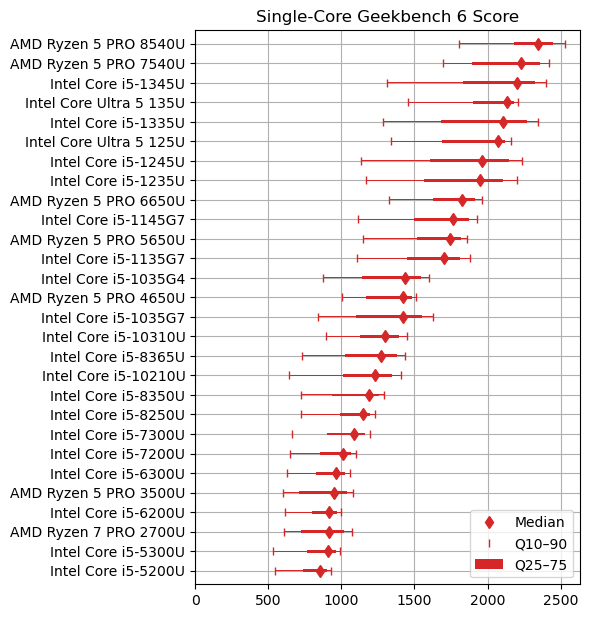

In [62]:
plot_stats(stats_plot, 'Single', sort_by=sort_by, color='tab:red')
plt.tight_layout()

Plot sorted by 'Multi q50' performance scores
Plot sorted by 'Multi q50' performance scores


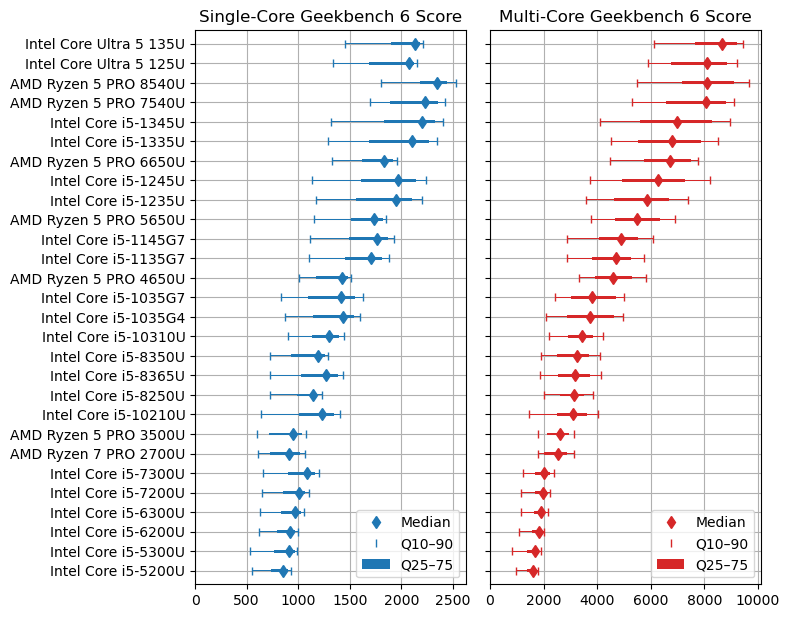

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(8,1+len(stats_plot)/5.3))

#sort_by = 'Single q50'
sort_by = 'Multi q50'
plot_stats(stats_plot, 'Single', sort_by, ax1, color='tab:blue')
plot_stats(stats_plot, 'Multi',  sort_by, ax2, color='tab:red')

fig.tight_layout()
fig.savefig(f'CPUs_GB6_stats_sort-{sort_by.replace(" ", "_")}.png', dpi=300)

Created animated GIF from the two sorted plots:

In [66]:
# delay in 1/100 second. Loop 0 = infinite
!convert -delay 200 -loop 0 CPUs_GB6_stats_sort-*.png CPUs_GB6_stats_sort-anim.gif

### Log2 scale variant

which allows superimposing single and multi core results

In [67]:
sortby = 'single'

if sortby == 'single':
    stats_plot = stats_plot.sort_values('Single q50')
elif sortby == 'multi':
    stats_plot = stats_plot.sort_values('Multi q50')
logstats_plot = np.log2(stats_plot/1000)
print(f'Plot sorted by {sortby}-core performance, log2 scale')

Plot sorted by single-core performance, log2 scale


Plot sorted by 'Single q50' performance scores
Plot sorted by 'Single q50' performance scores


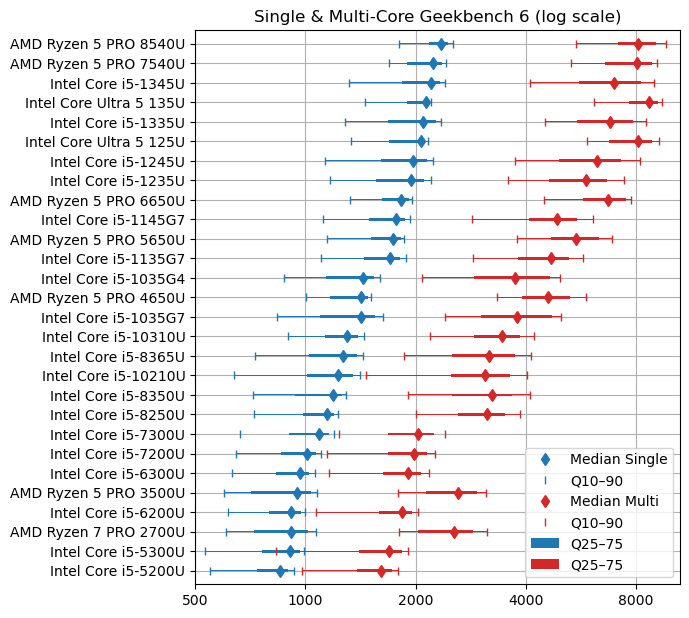

In [77]:
fig, ax = plt.subplots(figsize=(7,1+len(stats_plot)/5.3))

sort_by = 'Single q50'
#sort_by = 'Multi q50'
plot_stats(logstats_plot, 'Single', sort_by, color='tab:blue', ax=ax)
plot_stats(logstats_plot, 'Multi', sort_by, color='tab:red', ax=ax)

ax.set_xlim(-1, 3.4) # 500, ~10 000
log_ticks = [-1, 0, 1, 2, 3]
log_ticklabels = [f'{1000*2**i:.0f}' for i in log_ticks]
ax.set_xticks(log_ticks, log_ticklabels)
ax.set_title('Single & Multi-Core Geekbench 6 (log scale)')

# adjust labels and title
lines = ax.get_lines()
lines[0].set_label('Median Single')
lines[3].set_label('Median Multi')
ax.legend()

fig.tight_layout()
fig.savefig(f'CPUs_GB6_logstats_sort-{sort_by.replace(" ", "_")}.png', dpi=300)

Created animated GIF from the two sorted plots:

In [78]:
# delay in 1/100 second. Loop 0 = infinite
!convert -delay 200 -loop 0 CPUs_GB6_logstats_sort-*.png CPUs_GB6_logstats_sort-anim.gif